In [ ]:
try:
  from seqeval.metrics import classification_report, f1_score
except:
  !pip install seqeval
  from seqeval.metrics import classification_report, f1_score

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16162 sha256=512e0bf6525837e16342875d63400436a289595623f46124d8dedb6a756aa485
  Stored in directory: /root/.cache/pip/wheels/1a/67/4a/ad4082dd7dfc30f2abfe4d80a2ed5926a506eb8a972b4767fa
Successfully built seqeval


In [ ]:
try:
  from future.utils import iteritems
except:
  !pip install future
  from future.utils import iteritems

In [ ]:
import numpy as np
import pandas as pd
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras.optimizers import AdamW
from keras.metrics import CategoricalAccuracy
import tensorflow.keras.backend as K
from seqeval.metrics import classification_report, f1_score
from spacy import displacy
import spacy

2024-04-12 19:29:52.452805: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-12 19:29:52.452956: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-12 19:29:52.587435: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
df = pd.read_csv("/kaggle/input/ner-data/ner.csv", encoding = "ISO-8859-1", on_bad_lines="skip")
df = df.ffill()

In [ ]:
df.columns

Index(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'pos', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'sentence_idx', 'shape',
       'word', 'tag'],
      dtype='object')

In [ ]:
df = df.drop(['Unnamed: 0', 'lemma', 'next-lemma', 'next-next-lemma', 'next-next-pos',
       'next-next-shape', 'next-next-word', 'next-pos', 'next-shape',
       'next-word', 'prev-iob', 'prev-lemma', 'prev-pos',
       'prev-prev-iob', 'prev-prev-lemma', 'prev-prev-pos', 'prev-prev-shape',
       'prev-prev-word', 'prev-shape', 'prev-word', 'shape'],axis=1)

In [ ]:
df

,pos,sentence_idx,word,tag
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O
...,...,...,...,...
1050790,PRP,47959.0,they,O
1050791,VBD,47959.0,responded,O
1050792,TO,47959.0,to,O
1050793,DT,47959.0,the,O


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1050795 entries, 0 to 1050794
Data columns (total 4 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   pos           1050795 non-null  object 
 1   sentence_idx  1050795 non-null  float64
 2   word          1050795 non-null  object 
 3   tag           1050795 non-null  object 
dtypes: float64(1), object(3)
memory usage: 32.1+ MB


In [ ]:
df.head()

,pos,sentence_idx,word,tag
0,NNS,1.0,Thousands,O
1,IN,1.0,of,O
2,NNS,1.0,demonstrators,O
3,VBP,1.0,have,O
4,VBN,1.0,marched,O


In [ ]:
words = list(set(df['word'].values))
words.append("ENDPAD")
pos_tags = list(set(df['pos'].values))
tags = list(set(df['tag'].values))

In [ ]:
words_encoded = {word: i for i, word in enumerate(words)}
pos_encoded = {pos_tag: i for i, pos_tag in enumerate(pos_tags)}
ner_tag_encoded = {tag: i for i, tag in enumerate(tags)}
get_encoded_tag = {tag: i for i, tag in iteritems(ner_tag_encoded)}

In [ ]:
def combine(group):
   return [(word, pos, tag) for word, pos, tag in zip(group['word'].values.tolist(), group['pos'].values.tolist(), group['tag'].values.tolist())]

In [ ]:
def preprocess(df):
    df=df.groupby(['sentence_idx']).apply(combine, include_groups = True).reset_index().rename(columns={0:'combined'})
    df['sentence']=df['combined'].apply(lambda sentence:" ".join([s[0] for s in sentence]))
    df['pos']=df['combined'].apply(lambda sentence:" ".join([s[1] for s in sentence]))
    df['tag']=df['combined'].apply(lambda sentence:" ".join([s[2] for s in sentence]))
    df['tag_list']=df['tag'].apply(lambda tag: tag.split())
    df.drop("combined", inplace=True, axis=1)
    return df

In [ ]:
df_preprocessed = preprocess(df)
df_preprocessed.head()

/tmp/ipykernel_34/1500455423.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df=df.groupby(['sentence_idx']).apply(combine, include_groups = True).reset_index().rename(columns={0:'combined'})


,sentence_idx,sentence,pos,tag,tag_list
0,1.0,Thousands of demonstrators have marched throug...,NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP C...,O O O O O O B-geo O O O O O B-geo O O O O O B-...,"[O, O, O, O, O, O, B-geo, O, O, O, O, O, B-geo..."
1,2.0,Families of soldiers killed in the conflict jo...,NNS IN NNS VBN IN DT NN VBD DT NNS WP VBD NNS ...,O O O O O O O O O O O O O O O O O O B-per O O ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
2,3.0,They marched from the Houses of Parliament to ...,PRP VBD IN DT NNS IN NN TO DT NN IN NNP NNP . ...,O O O O O O O O O O O B-geo I-geo O O O O O O ...,"[O, O, O, O, O, O, O, O, O, O, O, B-geo, I-geo..."
3,4.0,"Police put the number of marchers at 10,000 wh...",NNS VBD DT NN IN NNS IN CD IN NNS VBD PRP VBD ...,O O O O O O O O O O O O O O O O O O O O O O O ...,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
4,5.0,The protest comes on the eve of the annual con...,DT NN VBZ IN DT NN IN DT JJ NN IN NNP POS VBG ...,O O O O O O O O O O O B-geo O O B-org I-org O ...,"[O, O, O, O, O, O, O, O, O, O, O, B-geo, O, O,..."


In [ ]:
sentences_list=df_preprocessed['sentence'].tolist()
tags_list=df_preprocessed['tag_list'].tolist()
for i, sentence in enumerate(sentences_list):
    sentences_list[i] = sentences_list[i].split()
print(sentences_list[0])
print('\n',tags_list[0])

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.', 'Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'the', 'withdrawal', 'of', 'British', 'troops', 'from', 'that', 'country', '.']

 ['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [ ]:
max_len = 140
X = [[words_encoded[w] for w in s] for s in sentences_list]
X = pad_sequences(maxlen=max_len, sequences=X, padding="post",value=len(words) - 1)
y = [[ner_tag_encoded[w] for w in s] for s in tags_list]
y = pad_sequences(maxlen=max_len, sequences=y, padding="post", value=ner_tag_encoded["O"])

In [ ]:
y = [to_categorical(i, num_classes=len(tags)) for i in y]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
input = Input(shape=(max_len,))
model = Embedding(input_dim=len(words), output_dim=300)(input)
model = Dropout(0.1)(model)
model = Bidirectional(LSTM(units=128, return_sequences=True, recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(len(tags), activation="softmax"))(model)
model = Model(input, out)

model_json = model.to_json()
with open("lstm_model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("lstm_model_weights.weights.h5")


model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 140)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 140, 300)       │     9,051,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 140, 300)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 140, 256)       │       439,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 140, 17)        │         4,369 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,495,265 (36.22 MB)

 Trainable params: 9,495,265 (36.22 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [ ]:
model.compile(optimizer=AdamW(learning_rate = 3e-3), loss="categorical_crossentropy", metrics=[CategoricalAccuracy(), f1_m,precision_m, recall_m])
history = model.fit(X_train, np.array(y_train), batch_size=256, epochs=5, validation_split=0.2, verbose=1)

Epoch 1/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 44s 347ms/step - categorical_accuracy: 0.9157 - f1_m: 0.9111 - loss: 0.3107 - precision_m: 0.9230 - recall_m: 0.9007 - val_categorical_accuracy: 0.9881 - val_f1_m: 0.9883 - val_loss: 0.0439 - val_precision_m: 0.9933 - val_recall_m: 0.9834
Epoch 2/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 326ms/step - categorical_accuracy: 0.9906 - f1_m: 0.9908 - loss: 0.0334 - precision_m: 0.9944 - recall_m: 0.9872 - val_categorical_accuracy: 0.9915 - val_f1_m: 0.9918 - val_loss: 0.0284 - val_precision_m: 0.9935 - val_recall_m: 0.9900
Epoch 3/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 328ms/step - categorical_accuracy: 0.9942 - f1_m: 0.9943 - loss: 0.0196 - precision_m: 0.9956 - recall_m: 0.9930 - val_categorical_accuracy: 0.9922 - val_f1_m: 0.9924 - val_loss: 0.0259 - val_precision_m: 0.9937 - val_recall_m: 0.9912
Epoch 4/5
88/88 ━━━━━━━━━━━━━━━━━━━━ 29s 328ms/step - categorical_accuracy: 0.9956 - f1_m: 0.9957 - loss: 0.0146 - precision_m: 0.9965 - recall_m: 0.9949 - val_categorical_

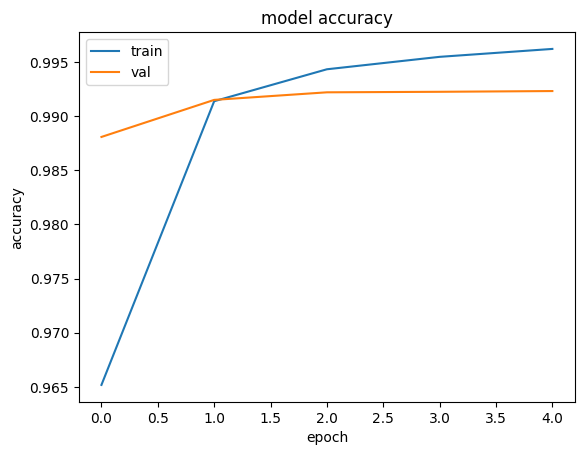

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

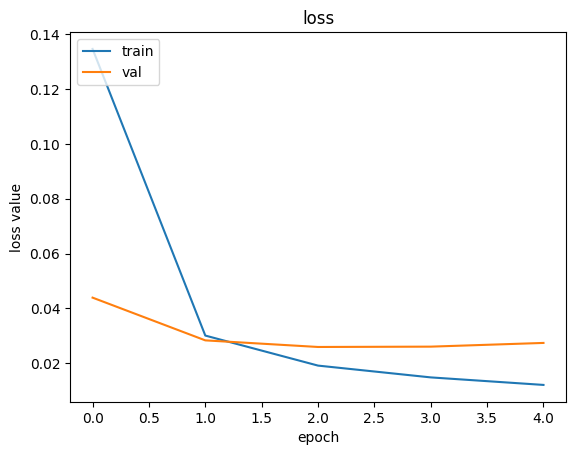

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.ylabel('loss value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

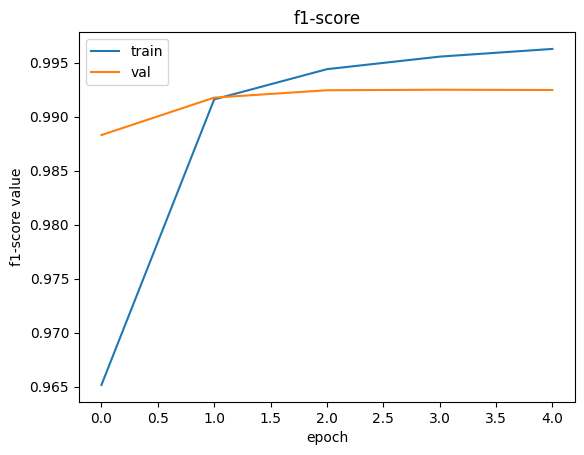

In [ ]:
plt.plot(history.history['f1_m'])
plt.plot(history.history['val_f1_m'])

plt.title('f1-score')
plt.ylabel('f1-score value')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
model.evaluate(X_test, np.asarray(y_test))

220/220 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - categorical_accuracy: 0.9929 - f1_m: 0.9930 - loss: 0.0250 - precision_m: 0.9937 - recall_m: 0.9923


[0.026211438700556755,
 0.9926000833511353,
 0.9927398562431335,
 0.9934624433517456,
 0.9920185208320618]

In [ ]:
def get_labels(predictions):
  output = []
  for pred in predictions:
    output_i = []
    for p in pred:
      p_i = np.argmax(p)
      output_i.append(get_encoded_tag[p_i])
    output.append(output_i)
  return output

In [ ]:
y_pred = model.predict(X_test)
prediction_labels = get_labels(y_pred)
test_labels = get_labels(y_test)

220/220 ━━━━━━━━━━━━━━━━━━━━ 17s 69ms/step


In [ ]:
print("f1 score on testing set: ", f1_score(test_labels, prediction_labels))

f1 score on testing set:  0.8018748301784259


In [ ]:
print(classification_report(test_labels, prediction_labels))

              precision    recall  f1-score   support

         art       0.17      0.01      0.02        83
         eve       0.30      0.24      0.27        58
         geo       0.83      0.87      0.85      7466
         gpe       0.96      0.93      0.95      3241
         nat       0.50      0.02      0.04        55
         org       0.69      0.63      0.66      3990
         per       0.72      0.68      0.69      3387
         tim       0.86      0.83      0.85      4054

   micro avg       0.81      0.79      0.80     22334
   macro avg       0.63      0.53      0.54     22334
weighted avg       0.81      0.79      0.80     22334



In [ ]:
for i in range(0, 5):
  text = X_test[i]
  p = model.predict(np.array([text]))
  p = np.argmax(p, axis=-1)
  gt = np.argmax(y_test[i], axis=-1)
  print("Test sentence:", i+1)
  print("{:14} {:5}: \t{}".format("Word", "True NER Labels", "Predicted NER labels"))
  for idx, (w,pred) in enumerate(zip(X_test[i],p[0])):
      if words[w] != "ENDPAD":
          print("{:14} {:5} \t\t\t{}".format(words[w], get_encoded_tag[gt[idx]], tags[pred]))
  print("\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step
Test sentence: 1
Word           True NER Labels: 	Predicted NER labels
But            O     			O
for            O     			O
the            O     			O
past           B-tim 			B-tim
two            I-tim 			I-tim
years          O     			O
,              O     			O
Norwegian      B-gpe 			B-gpe
whale          O     			O
hunters        O     			O
have           O     			O
fallen         O     			O
short          O     			O
of             O     			O
the            O     			O
quotas         O     			O
.              O     			O


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
Test sentence: 2
Word           True NER Labels: 	Predicted NER labels
The            O     			O
victims        O     			O
were           O     			O
passengers     O     			O
of             O     			O
a              O     			O
minibus        O     			O
passing        O     			O
through        O     			O
an             O     			O
area           O     			O
known          O     			O
as           

In [ ]:
# Try to get this working

# # nlp = spacy.load("en_core_web_sm")
# from keras.models import model_from_json
# # Load the saved model architecture from JSON
# with open("lstm_model.json", "r") as json_file:
#     loaded_model_json = json_file.read()

# loaded_model = model_from_json(loaded_model_json)
# # loaded_model.load_weights("lstm_model_weights.weights.h5")

# Visualize NER tagging on test set examples with spacy
nlp = spacy.load("en_core_web_sm")
# nlp_entity = spacy.load("lstm_model.json")
# nlp.add_pipe("ner", source=loaded_model)
for i in range(0, 5):
  text = X_test[i]
  spacy_str = []
  for w in text:
    if words[w] != "ENDPAD":
      spacy_str.append(words[w])
  spacy_str = ' '.join(spacy_str)
  doc = nlp(str(spacy_str))
  print("{}. ".format(i+1))
  displacy.render(doc, style="ent")
  print("\n")

1. 




2. 


/opt/conda/lib/python3.10/site-packages/spacy/displacy/__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)




3. 




4. 




5. 
